In [1]:
import torch
from torch.functional import F
import matplotlib.pyplot as plt
import numpy as np
from PyTorch_LBFGS import FullBatchLBFGS
from torch.autograd import Function



## Fluid Solver

In [11]:
class Solver(object):
    """123
    """
    def __init__(self):
        
        super().__init__()
        self.res_x = torch.tensor(64)
        # self.res_y = (self.res_x*1.5).to(torch.int32)
        self.res_y = self.res_x
        
        self.dt = 0.05 * np.sqrt((self.res_x + self.res_y) * 0.5)
        self.dx = 1.
        self.rho = 1.
        
        self.A = None

    
    def advectValues(self, density, vel):

        density_adv = self.advectDensitySL(density, vel)
        vel_adv = self.advectVelocitySL(vel)
        return density_adv, vel_adv

    def advectDensitySL(self, density, vel):
        _, res_y, res_x = density.shape
        y_pos, x_pos = torch.meshgrid([torch.arange(0, res_y, dtype=torch.float32), torch.arange(0, res_x, dtype=torch.float32)])
        mgrid = torch.stack([x_pos, y_pos], dim=0)

        last_vx = 0.5 * (vel[0, :-1, :-1] + vel[0, :-1, 1:])
        last_vy = 0.5 * (vel[1, :-1, :-1] + vel[1, 1:, :-1])
        backtrace = mgrid - torch.stack((last_vx, last_vy), dim=0)*self.dt
        
        backtrace_normed_x = 2 * backtrace[0:1, ...] / (res_x-1) - 1
        backtrace_normed_y = 2 * backtrace[1:2,...] / (res_y-1) - 1
        backtrace_normed = torch.cat((backtrace_normed_x, backtrace_normed_y), dim=0)
        
        permutation = (1,2,0)
        backtrace_normed = backtrace_normed.permute(permutation).unsqueeze(0)
        density = density.unsqueeze(0)
        grid_sampled = F.grid_sample(density, backtrace_normed, padding_mode="border", align_corners=True)
        grid_sampled = grid_sampled.squeeze(0)

        return grid_sampled

    def advectVelocitySL(self, vel):
        _, res_y, res_x = vel.shape
        y_pos, x_pos = torch.meshgrid([torch.arange(0, res_y, dtype=torch.float32), torch.arange(0, res_x, dtype=torch.float32)])
        mgrid = torch.stack([x_pos, y_pos], dim=0)

        # advect vx
        last_vx = vel[0, ...]
        pad_y = (1,0,0,1)
        pad_vy = F.pad(vel[1,...], pad_y)
        last_vy = 0.25 * (pad_vy[:-1, :-1] + pad_vy[1:, :-1] + pad_vy[:-1, 1:] + pad_vy[1:, 1:])
        backtrace = mgrid - torch.stack((last_vx, last_vy), dim=0)*self.dt
        backtrace_normed_x = 2 * backtrace[0:1, ...] / (res_x-1) - 1
        backtrace_normed_y = 2 * backtrace[1:2,...] / (res_y-1) - 1
        backtrace_normed = torch.cat((backtrace_normed_x, backtrace_normed_y), dim=0)
        permutation = (1,2,0)
        backtrace_normed = backtrace_normed.permute(permutation).unsqueeze(0)
        vx = vel[0:1, ...]
        vx = vx.unsqueeze(0)
        grid_sampled = F.grid_sample(vx, backtrace_normed, padding_mode="border", align_corners=True)
        vx_adv = grid_sampled.squeeze(0)

        # advect vy
        pad_x = (0,1,1,0)
        pad_vx = F.pad(vel[0,...], pad_x)
        last_vx = 0.25 * (pad_vx[1:, 1:] + pad_vx[:-1, 1:] + pad_vx[1:, :-1] + pad_vx[:-1, :-1])
        last_vy = vel[1, ...]
        backtrace = mgrid - torch.stack((last_vx, last_vy), dim=0)*self.dt
        backtrace_normed_x = 2. * backtrace[0:1, ...] / (res_x-1) - 1.
        backtrace_normed_y = 2. * backtrace[1:2,...] / (res_y-1) - 1.
        backtrace_normed = torch.cat((backtrace_normed_x, backtrace_normed_y), dim=0)
        permutation = (1,2,0)
        backtrace_normed = backtrace_normed.permute(permutation).unsqueeze(0)
        vy = vel[1:2, ...]
        vy = vy.unsqueeze(0)
        grid_sampled = F.grid_sample(vy, backtrace_normed, padding_mode="border", align_corners=True)
        vy_adv = grid_sampled.squeeze(0)        

        return torch.cat((vx_adv, vy_adv), dim=0)

    def applySource(self, density, source):
        xmin, xmax, ymin, ymax = source
        _, res_y, res_x = density.shape
        density[0, int(ymin*res_y):int(ymax*res_y), int(xmin*res_x):int(xmax*res_x)] = 1.
        return density

    def addBuoyancy(self, density, vel):
        _, _, res_x = density.shape
        pad = (0,1,1,1)
        density_pad = F.pad(density, pad)
        scaling = 64. / res_x
        f = 0.5 * (density_pad[:, 1:, :] + density_pad[:, :-1, :]) * 0.256 * scaling
        vel_x = vel[0:1, ...]
        vel_y = vel[1:2, ...] + f * self.dt
        return torch.cat((vel_x, vel_y), dim=0)

    def addWind(self):
        self.f[0, :,:] = .005

    def addForce(self, vel, force):
        vel = vel + self.dt * force * 64
        return vel

    def solvePressure(self, vel):
        if (self.A==None):
            _, res_y, res_x = vel.shape
            Adiag = 4 * torch.ones(res_y-1, res_x-1) + 1e-3
            Aoffd = -1 * torch.ones(res_y-1, res_x-1)
            self.A = torch.stack([Adiag, Aoffd])

        div = self.computeDivergence(vel)
        pressure = self.solvePoisson(div)
        vel = self.correctVelocity(vel, pressure)
        return vel

    def computeDivergence(self, vel):
        dudx = (vel[0:1, :-1, 1:] - vel[0:1, :-1, :-1]) / self.dx
        dvdy = (vel[1:2, 1:, :-1] - vel[1:2, :-1, :-1]) / self.dx
        div = dudx + dvdy
        return div

    # matrix-vector mult
    def _Mv(self, A, b):
        Ab = torch.zeros(b.size())
        Adiag = A[0, ...]
        Aoffd = A[1, ...]
        pad_x = (1,1,0,0)
        pad_y = (0,0,1,1)
        b_pad_x = F.pad(b, pad_x)
        b_pad_y = F.pad(b, pad_y)
        Ab = Adiag*b + Aoffd*(b_pad_x[..., 2:] + b_pad_x[..., :-2] + b_pad_y[..., 2:, :] + b_pad_y[..., :-2, :])
        return Ab
    # cg
    def _solve_lse(self, rhs, A, acc=1e-5, it_max=1000):
        _, res_y, res_x = A.shape
        pressure = torch.zeros(res_y, res_x)
        r = rhs.clone()
        if (torch.norm(r, np.inf)) <= acc:
            return pressure
        z = r
        s = z.clone()
        sigma = torch.sum(z * r)
        for t in range(it_max):
            z = self._Mv(A, s)
            alpha = sigma / torch.sum(z*s)
            pressure = pressure + alpha*s
            r = r - alpha * z
            if (torch.norm(r, np.inf)) <= acc:
                return pressure
            z = r
            sigma_new = torch.sum(z*r)
            beta = sigma_new / sigma
            s = z + beta * s
            sigma = sigma_new
        print("solve Poisson failed: ", t, " ", torch.norm(r, np.inf))
        return pressure

    def solvePoisson(self, div, acc = 1e-5, it_max = 6000):
        solve_lse_fcn = self._solve_lse
        class solvePoissonOverwrite(Function):
            @staticmethod
            def forward(ctx, rhs, A):
                p = solve_lse_fcn(rhs, A, acc, it_max)
                ctx.save_for_backward(A, p)
                return p
            
            @staticmethod
            def backward(ctx, grad_output):
                A, p = ctx.saved_tensors
                grad_rhs = solve_lse_fcn(grad_output, A, 1e-10) #chain rule
                grad_Adiag = -grad_rhs * p #adjoint, dg/dx dx/dA, s.t. A dx/dA=-x
                padx = (0, 1, 0, 0)
                pady = (0, 0, 0, 1)
                p_padx = F.pad(p, pad=padx)
                grad_rhs_padx = F.pad(grad_rhs, pad=padx)
                p_pady = F.pad(p, pad=pady)
                grad_rhs_pady = F.pad(grad_rhs, pad=pady)
                # twist due to sparse format
                grad_Aoffd = -grad_rhs * p_padx[..., 1:] - grad_rhs_padx[..., 1:] * p - grad_rhs * p_pady[..., 1:, :] - grad_rhs_pady[..., 1:, :] * p
                grad_A = torch.stack([grad_Adiag, grad_Aoffd])
                return grad_rhs, grad_A

        rhs = -div / self.dt * self.rho
        solve = solvePoissonOverwrite.apply
        p = solve(rhs, self.A)

        return p

    def correctVelocity(self, vel, pressure):

        pad = (1,1,1,1)
        pad_p = F.pad(pressure, pad)
        diff_px = pad_p[:, 1:, 1:] - pad_p[:, 1:, :-1]
        diff_py = pad_p[:, 1:, 1:] - pad_p[:, :-1, 1:]
        diff_p = torch.cat((diff_px, diff_py), dim=0)
        vel_corrected = vel - diff_p * self.dt / self.dx
        return vel_corrected



## Test Solver

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


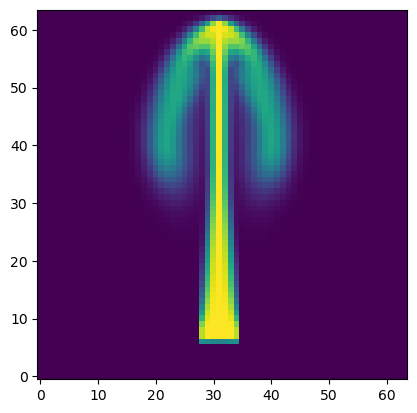

tensor(398.1888)


In [4]:
res_x = torch.tensor(64)
# res_y = (res_x*1.5).to(torch.int32)
res_y = res_x
density = torch.zeros(1, res_y, res_x)
vel = torch.zeros(2, res_y+1, res_x+1)
force = torch.zeros(2, res_y+1, res_x+1)
# force[0, ...] = .0001
source = (.45, .55, .1, .15)

m = Solver()
for i in range(120):
    print(i)
    # if (i<95):
    density = m.applySource(density, source)
    density, vel = m.advectValues(density, vel)
    vel = m.addBuoyancy(density, vel)
    vel = m.addForce(vel, force)
    vel = m.solvePressure(vel)
# torch.save(density, "t100.pt")
fig, ax = plt.subplots()

ax.imshow(density[0], origin="lower")

plt.show()
print(density.sum())

## Build Target

tensor(236.6229)


/Users/xpy/anaconda3/envs/pbs/lib/python3.11/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


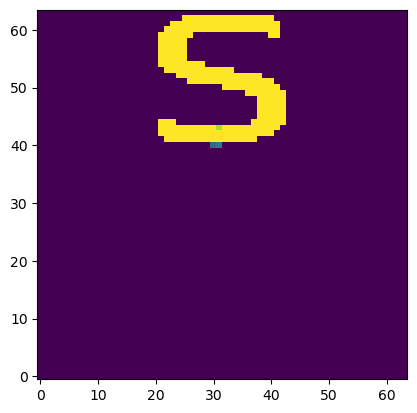

In [5]:
res_x = torch.tensor(64)
# res_y = (res_x*1.5).to(torch.int32)
res_y = res_x
fig, ax = plt.subplots()
s = plt.imread("s.png")
s = s[..., 3]
s = torch.from_numpy(s)
s = torch.flip(s, [0])
s = s.view(1, 1, s.shape[0], s.shape[1])
# s.shape
d = torch.linspace(-1, 1, 24)
meshx, meshy = torch.meshgrid((d, d))
grid = torch.stack((meshy, meshx), 2)
grid = grid.unsqueeze(0)
output = torch.nn.functional.grid_sample(s, grid)
# output.shape
target = torch.zeros((1,res_y,res_x))
target[0,-24:, 20:44] = output[0,0]
ax.imshow(target[0], origin="lower")
print(target.sum())

## Optimization

In [12]:
class Model(torch.nn.Module):
    def __init__(self, solver, source, source_time):
        super().__init__()
        self.solver = solver

        self.source = source
        self.source_time = source_time

        self.param = torch.nn.Parameter(torch.zeros((2, solver.res_y+1, solver.res_x+1), dtype=torch.float32))

    def compute_force(self):
        # avoid registering self.force as nn.Parameter
        self.force = self.param + 0.0

    def get_force(self):
        return self.force
    
    def forward(self, density, vel, t, force_rescale_factor=1.0):
        force = self.force * force_rescale_factor
        if (t < self.source_time):
            density = self.solver.applySource(density, self.source)
        density, vel = self.solver.advectValues(density, vel)
        vel = self.solver.addBuoyancy(density, vel)
        vel = self.solver.addForce(vel, force)
        vel = self.solver.solvePressure(vel)

        return density, vel


In [13]:
class TotoalVariation(torch.nn.Module):
    def forward(self, input):
        w_variance = torch.sum(torch.pow(input[..., :-1] - input[..., 1:], 2))
        h_variance = torch.sum(torch.pow(input[..., :-1, :] - input[..., 1:, :], 2))
        return w_variance + h_variance
    
class Optimization(object):
    def __init__(self, solver) -> None:
        self.solver = solver
        self.density_init = torch.zeros((1, self.solver.res_y, self.solver.res_x))
        self.vel_init = torch.zeros((2, self.solver.res_y+1, self.solver.res_x+1))
        source = (.3, .7, .1, .3)
        source_time = 1
        self.model = Model(self.solver, source, source_time)
        self.objective_pointwise = torch.nn.MSELoss(reduction="mean")
        self.objective_list = [self.objective_pointwise]
        self.keyframe = 90
        # target = torch.load("t100.pt")
        self.targets = {}
        self.targets.update({self.keyframe: target})
        self.tv = TotoalVariation()
        self.lambd_tv_reg = 10.0
        self.lr = 1

    def compute_objective(self, phase):
        self.objective = 0.0
        self.tv_objective = 0.0
        density = self.density_init.detach()
        vel = self.vel_init.detach()

        self.model.compute_force()
        for t in range(self.keyframe):
            density, vel = self.model(density, vel, t)
            frame = t + 1
            if frame in list(self.targets.keys()):
                target = self.targets[frame]
                self.objective += self.objective_list[phase](density, target)

        for force in self.model.get_force():
            self.tv_objective += self.tv(force)

        self.objective = (self.objective + self.lambd_tv_reg * self.tv_objective)
        return self.objective

    def get_current_objective(self):
        objective_dict = {"total_objective": self.objective.item()}
        objective_dict.update({"tv_objective": self.tv_objective.item()})
        return objective_dict
    
    def set_optimization(self, phase):
        self.optimizer = FullBatchLBFGS(self.model.parameters(), lr=self.lr, line_search="Wolfe", history_size=10)

    def optimize_parameters(self, phase, is_first_step=False):
        def closure_pytorch_lbfgs():
            self.optimizer.zero_grad()
            self.compute_objective(phase)
            return self.objective
        if is_first_step:
            closure_pytorch_lbfgs()
            self.objective.backward()
        options = {
            "closure": closure_pytorch_lbfgs,
            "current_objective": self.objective,
            "max_ls": 25,
            "inplace": False,
        }
        _, _, t, _, F_eval, G_eval, _, fail = self.optimizer.step(options)
        message = (
            "# fcn eval: {}, # grad eval: {}, "
            "final step size: {}, failure of line search: {}".format(
                F_eval, G_eval, t, fail
            )
        )
        return message, fail
    
    def simulate(self):
        self.model.compute_force()
        density = self.density_init.detach()
        vel = self.vel_init.detach()
        force_rescale_factor = 1.0
        fig, ax = plt.subplots()
        for t in range(self.keyframe):
            frame = t + 1
            density, vel = self.model(density, vel, t, force_rescale_factor)
            ax.imshow(density[0].detach(), origin='lower')
            plt.savefig("imgs/{:03d}.png".format(t), dpi=150)
            if frame in [self.keyframe]:
                ax.imshow(density[0].detach(), origin='lower')
                plt.savefig("keyframe.png", dpi=150)

    
    


0 :  # fcn eval: 9, # grad eval: 1, final step size: 0.0007471496371353986, failure of line search: False , Loss:  0.06152815371751785
1 :  # fcn eval: 2, # grad eval: 1, final step size: 1, failure of line search: False , Loss:  0.05195106938481331
2 :  # fcn eval: 2, # grad eval: 1, final step size: 1, failure of line search: False , Loss:  0.04877720773220062
3 :  # fcn eval: 2, # grad eval: 1, final step size: 1, failure of line search: False , Loss:  0.0468924306333065
4 :  # fcn eval: 3, # grad eval: 1, final step size: 0.3496722103478077, failure of line search: False , Loss:  0.046174462884664536
5 :  # fcn eval: 2, # grad eval: 1, final step size: 1, failure of line search: False , Loss:  0.04349811375141144
6 :  # fcn eval: 2, # grad eval: 1, final step size: 1, failure of line search: False , Loss:  0.04305757209658623
7 :  # fcn eval: 2, # grad eval: 1, final step size: 1, failure of line search: False , Loss:  0.0423666276037693
8 :  # fcn eval: 2, # grad eval: 1, final st

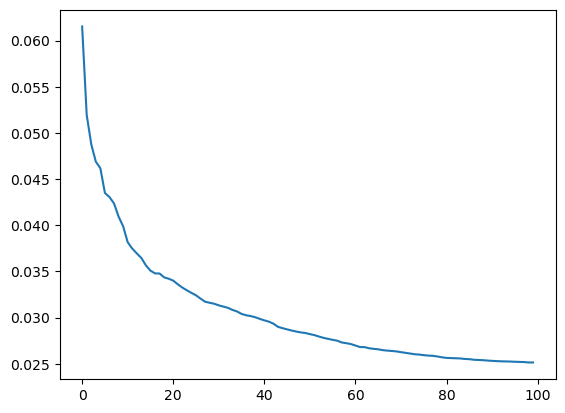

In [14]:
s = Solver()
optimization = Optimization(s)
optimization.set_optimization(0)
    
loss = []
for i in range(100):
    message, fail = optimization.optimize_parameters(0, is_first_step=(i==0))
    objective_dict = optimization.get_current_objective()
    loss.append(objective_dict["total_objective"])
    print(i, ": ", message, ", Loss: ", objective_dict["total_objective"])
# torch.save(optimization.model.state_dict(), "100.pth")
plt.plot(loss)

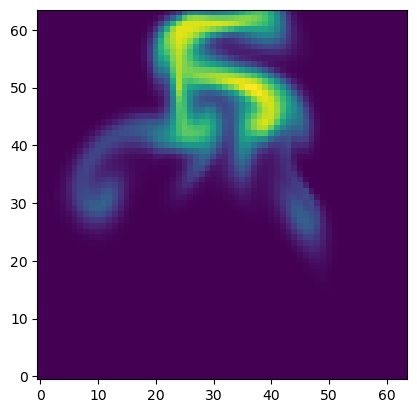

In [16]:
# optim = Optimization(s)
# optim.model.load_state_dict(torch.load("123.pth"))
# optim.simulate()
optimization.simulate()